In [1]:
import numpy as np
from numpy.fft import fft
import matplotlib.pyplot as plt
import scipy.io.wavfile as spwav
#from mpldatacursor import datacursor
import sys
from IPython.display import Audio

plt.style.use('ggplot')

# Note: this epoch list only holds for "test_vector_all_voiced.wav"
epoch_marks_orig = np.load("test_vector_all_voiced_epochs.npy")
F_s, audio_data = spwav.read("test_vector_all_voiced.wav")
N = len(audio_data)

In [33]:
def tune(audio_data, F_new):
    N = len(audio_data)
    new_epoch_spacing = int(np.round(F_s / F_new))
    audio_out = np.zeros(N)
    
    epoch_idx = 1
    for i in range(0, N, new_epoch_spacing):        
        # find the closest epoch
        dists = np.abs(epoch_marks_orig[epoch_idx - 1:epoch_idx + 2] - i)
        j = np.argmin(dists)
        epoch_idx += j
        epoch_idx = np.minimum(epoch_idx, epoch_marks_orig.shape[0] - 2)
        closest_epoch = epoch_marks_orig[epoch_idx]
    
        # approximate impulse response with hamming window
        P_0 = int(np.abs(epoch_marks_orig[epoch_idx + 1] - epoch_marks_orig[epoch_idx - 1]) / 2)
    
        h = np.float32(audio_data[closest_epoch-P_0:closest_epoch+P_0+1])

        # normalize h (can play around with diff methods)
        h /= np.max(h2) # np.sum(h * h)
        
        windowLength = 2 * P_0 + 1
        hWindowed = h * np.hanning(windowLength)
    
        # overlap and add
        length = np.minimum(i+windowLength, N) - i
        audio_out[i:i+length] += hWindowed[:length]

    return audio_out

tuned_audio = tune(audio_data, 440)

#### Get Target Pitch From Note Number

In [23]:
def noteToFreq(noteNumber):
    return 440 * 2**((noteNumber - 69) / 12)

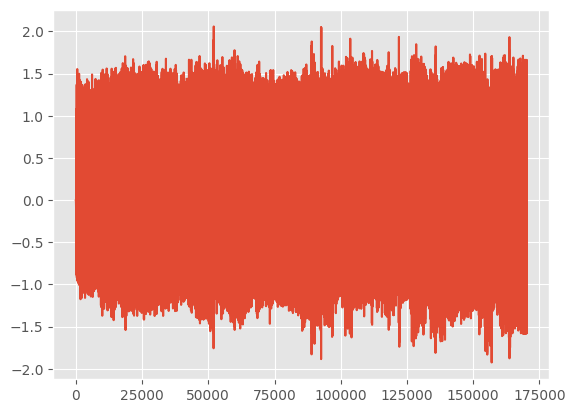

In [36]:
freq = noteToFreq(69) # A 440hz
tuned_audio = tune(audio_data, freq)
Audio(tuned_audio, rate=F_s)
plt.plot(tuned_audio)

#### ADSR

In [ ]:
def envelope_